In [2]:
import functools
import numpy as np
import scipy
import sympy
import matplotlib.pyplot as plt
import keras
import keras.backend as K
sympy.init_printing()

Using TensorFlow backend.


In [47]:
a,b,c,d = sympy.symbols('a,b,c,d', real=True)
F = sympy.exp(-(c)**2) * sympy.sin(a+d) + b
iF = F.integrate(a)
lambda_F = sympy.lambdify((a,b,c,d), F)
lambda_iF = sympy.lambdify((a,b,c,d), iF, modules=['numpy', {'erf': scipy.special.erf}])
display((F, iF))

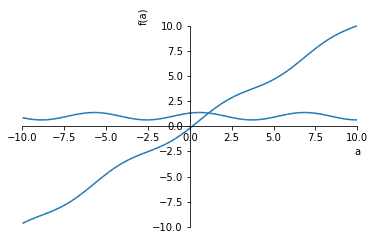

In [48]:
sympy.plot(F.subs({b:1,c:1,d:1}), iF.subs({b:1,c:1,d:1}))

In [58]:
xtrain = (np.random.random((100000,4)) - 0.5) * 20
xtest = (np.random.random((10000,4)) - 0.5) * 20
xtest[:,1:] = np.round(xtest[:,1:]/3)*3
xtest[:,2:] = xtest[:,1:2]
ytrain, ytest = lambda_F(*np.hsplit(xtrain,4)), lambda_F(*np.hsplit(xtest,4))

In [51]:
def build_nn_pair():
    X = X_input = keras.layers.Input((4,))
    X = keras.layers.BatchNormalization()(X)
    X = keras.layers.Dense(128, activation='tanh')(X)
    for _ in range(3):
        X_skip = X
        X = keras.layers.Dense(128, activation='relu')(X)
        X = keras.layers.Dense(128)(X)
        X = keras.layers.Add()([X, X_skip])
        X = keras.layers.Activation('tanh')(X)
    X = keras.layers.Dense(1)(X)
    M_Integral = keras.Model(X_input, X)
    M_Integral.compile('nadam', 'mse', ['mae'])
    X = M_Integral(X_input)
    def compute_jacobian(x):
        return K.reshape(K.stack([
            K.gradients(x[1][:,ix], x[0])[0]
            for ix in range(1)
        ], axis=1), (-1,1,4))
    def compute_grad(x):
        j = compute_jacobian(x)
        return j[:,0,:1]
    X = keras.layers.Lambda(
        lambda x: compute_grad(x) + K.sum(x[1])*0,
        output_shape=(1,))([X_input, X])
    M_DIntegral = keras.Model(X_input, X)
    M_DIntegral.compile('nadam', 'mse', ['mae'])
    return M_Integral, M_DIntegral

In [52]:
M_Integral, M_DIntegral = build_nn_pair()
M = M_DIntegral
M.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 4)            0                                            
__________________________________________________________________________________________________
model_9 (Model)                 (None, 1)            99857       input_5[0][0]                    
__________________________________________________________________________________________________
lambda_5 (Lambda)               (None, 1)            0           input_5[0][0]                    
                                                                 model_9[1][0]                    
Total params: 99,857
Trainable params: 99,849
Non-trainable params: 8
__________________________________________________________________________________________________


In [ ]:
M.optimizer.lr.assign(1e-6)
M.fit(xtrain, ytrain, validation_data=(xtest, ytest), batch_size=256, epochs=50, callbacks=[
    keras.callbacks.ReduceLROnPlateau(patience=5, verbose=1),
])

Train on 100000 samples, validate on 10000 samples
Epoch 1/50
100000/100000 [==============================] - 4s 36us/step - loss: 0.3507 - mean_absolute_error: 0.4652 - val_loss: 0.7681 - val_mean_absolute_error: 0.7217
Epoch 2/50
100000/100000 [==============================] - 4s 36us/step - loss: 0.3714 - mean_absolute_error: 0.4785 - val_loss: 0.6268 - val_mean_absolute_error: 0.6637
Epoch 3/50
100000/100000 [==============================] - 4s 37us/step - loss: 0.3526 - mean_absolute_error: 0.4596 - val_loss: 0.4170 - val_mean_absolute_error: 0.5400
Epoch 4/50
100000/100000 [==============================] - 4s 37us/step - loss: 0.3627 - mean_absolute_error: 0.4710 - val_loss: 0.4307 - val_mean_absolute_error: 0.5400
Epoch 5/50
100000/100000 [==============================] - 4s 37us/step - loss: 0.3497 - mean_absolute_error: 0.4649 - val_loss: 0.4354 - val_mean_absolute_error: 0.5288
Epoch 6/50
100000/100000 [==============================] - 4s 37us/step - loss: 0.3678 - mean

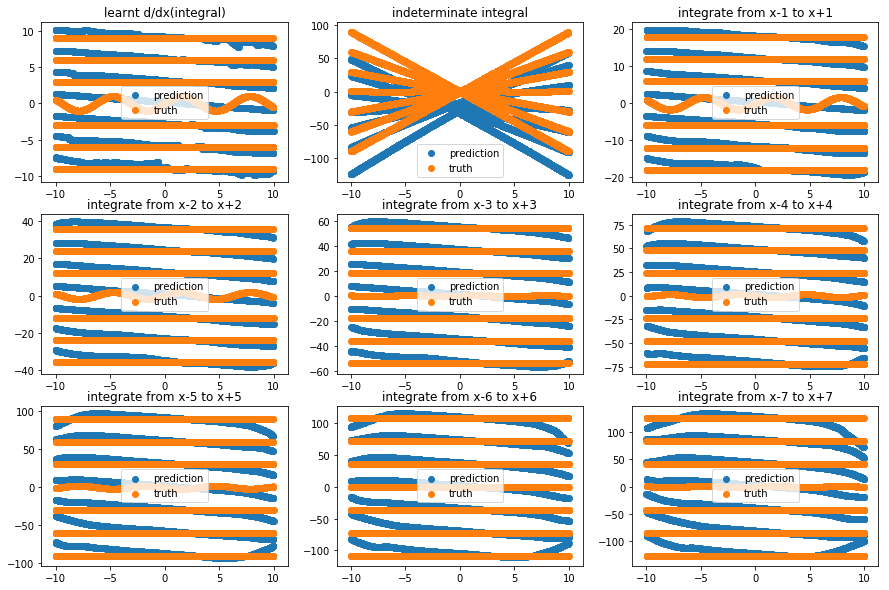

In [63]:
plt.figure(figsize=(15,10))
plt.subplot(3,3,1)
plt.title('learnt d/dx(integral)')
plt.scatter(xtest[:,0], M_DIntegral.predict(xtest), label='prediction')
plt.scatter(xtest[:,0], lambda_F(*np.hsplit(xtest, 4)), label='truth')
plt.legend()
plt.subplot(3,3,2)
plt.title('indeterminate integral')
plt.scatter(xtest[:,0], M_Integral.predict(xtest), label='prediction')
plt.scatter(xtest[:,0], lambda_iF(*np.hsplit(xtest, 4)), label='truth')
plt.legend()
for i in range(7):
    D = (i+1)
    plt.subplot(3,3,i+3)
    plt.title(f'integrate from x-{D} to x+{D}')
    plt.scatter(xtest[:,0],
                M_Integral.predict(np.hstack([xtest[:,:1] + D, *np.hsplit(xtest[:,1:], 3)])) - \
                M_Integral.predict(np.hstack([xtest[:,:1] - D, *np.hsplit(xtest[:,1:], 3)])),
                label='prediction')
    plt.scatter(xtest[:,0],
                lambda_iF(xtest[:,:1] + D, *np.hsplit(xtest[:,1:], 3)) - \
                lambda_iF(xtest[:,:1] - D, *np.hsplit(xtest[:,1:], 3)),
                label='truth')
    plt.legend()
plt.show()